In [48]:
import sys, os
import numpy as np

from scipy.optimize import minimize_scalar, newton
from scipy.integrate import quad
import scipy.signal as sig
from scipy.special import erf
from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

*Note.* For concreteness, we calculate the differential rate $dR/dq$ for a fixed DM mass, coupling, and mediator mass.

## Parameters

In [3]:
hbarc = 0.2     # eV um
rho_T = 2.0e3   # Sphere density, kg/m^3
mAMU = 1.66e-27 # Neutron mass

### Experiment parameters

In [4]:
R_um = 5          # Sphere radius, um
R = R_um / hbarc  # Radius in natural units, eV^-1

N_T = 0.5 * ( 4/3 * np.pi * (R_um*1e-6)**3) * rho_T/mAMU # Number of neutrons
res = 170e6       # detector resolution in eV

q_thr = 0.05e9    # momentum threshold, eV

### DM parameters

In [5]:
M_X_in = 5e3         # GeV
alpha_n_in = 1e-8    # Gev
m_phi = 0.0001       # Mediator mass, eV

In [6]:
M_X = M_X_in * 1e9   # Dark matter nugget mass, eV (assumes mass in GeV given on command line)
m_chi = 0.01 * 1e9   # eV
N_chi = M_X / m_chi  # Number of dark matter particles in the nugget

rhoDM = 0.3e9        # dark matter mass density, eV/cm^3

alpha_n = alpha_n_in # Dimensionless single neutron-nugget coupling
alpha = alpha_n * N_T # Coupling of the entire sphere
mR = m_phi * R        # (= R/lambda), a useful length scale; now defiend in `vtot()`

Some parameters related to DM velocity distribution.

In [7]:
vmin = 5e-5      # minimum velocity to consider, natural units (c)
vesc = 1.815e-3  # galactic escape velocity
v0 = 7.34e-4     # v0 parameter from Zurek group paper
ve = 8.172e-4    # ve parameter from Zurek group paper

## Defining functions

### Yukawa potential

In [10]:
def vtot_func(u, m_phi=m_phi, alpha=alpha):
    """Exact Yukawa potential for a uniform density sphere
    
    Parameters
    ----------
    u : float
        Distance inverse 1/r in eV
    m_phi : float
        Mediator mass in eV
    alpha : float
        Dimensionless DM coupling to the sphere
        
    Returns
    -------
    float
        Potential V(u) in eV
    """
    mR = m_phi * R
    
    # Devide the array of u=1/r into three cases
    if (u < 1e-10) : return np.inf
    if (u < 1/R):  # outside
        return 3 * alpha/mR**3 * (mR * np.cosh(mR) - np.sinh(mR)) * np.exp(-m_phi/u) * u
    else:          # inside
        return 3 * alpha/mR**3 * (m_phi - u*(1 + mR)/(1+1./np.tanh(mR)) * (np.sinh(m_phi/u)/np.sinh(mR)))

In [11]:
def vtot(u, m_phi=m_phi, alpha=alpha):
    """Exact Yukawa potential for a uniform density sphere
    
    Parameters
    ----------
    u : float, array-like
        Distance inverse 1/r in eV
    m_phi : float
        Mediator mass in eV
    alpha : float
        Dimensionless DM coupling to the sphere
        
    Returns
    -------
    float, array-like
        Potential V(u) for each u in eV
    """
    mR = m_phi * R
    
    u = np.asarray(u)
    ret = np.empty_like(u)
    
    # Devide the array of u=1/r into three cases
    neg     = (u <= 0)   # ill-defined
    outside = (u < 1/R)  # ouside sphere
    inside  = (u >= 1/R) # inside sphere
    
    ret[neg] = np.inf
    
    if(mR > 0):   # massive mediator
        ret[outside] = 3 * alpha/mR**3 * (mR * np.cosh(mR) - np.sinh(mR)) * np.exp(-m_phi/u[outside]) * u[outside]
        ret[inside] = 3 * alpha/mR**3 * (m_phi - u[inside]*(1 + mR)/(1+1./np.tanh(mR)) * (np.sinh(m_phi/u[inside])/np.sinh(mR)))
        
    else:         # massless mediator (alpha/r)
        ret[outside] = alpha * u[outside]
        ret[inside] = alpha/2 * (3/R - 1./(R**3 * u[inside]**2))

    return ret

Text(0, 0.5, 'v(r)')

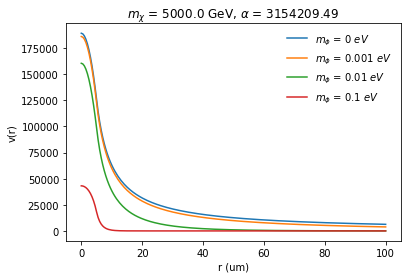

In [12]:
# Plotting the potential
r_um = np.linspace(1e-8, 100, 200)
r = r_um / hbarc # convert to eV

plt.plot(r_um, vtot(1/r, m_phi=0), label='$m_\phi$ = 0 $eV$')
plt.plot(r_um, vtot(1/r, m_phi=0.001), label='$m_\phi$ = 0.001 $eV$')
plt.plot(r_um, vtot(1/r, m_phi=0.01), label='$m_\phi$ = 0.01 $eV$')
plt.plot(r_um, vtot(1/r, m_phi=0.1), label='$m_\phi$ = 0.1 $eV$')

plt.title(fr'$m_\chi$ = {M_X_in} GeV, $\alpha$ = {alpha:.2f}')
plt.legend(frameon=False)
plt.xlabel('r (um)')
plt.ylabel('v(r)')

### Other functions (not organized yet)

In [13]:
def get_color_map(n):
    jet = plt.get_cmap('jet') 
    cNorm  = colors.Normalize(vmin=0, vmax=n-1)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    outmap = []
    for i in range(n):
        outmap.append( scalarMap.to_rgba(i) )
    return outmap

## function used to smear the spectrum with gaussian resolution
def res_fun( x, sig ):
    return 1.0/(sig * np.sqrt(2*np.pi)) * np.exp(-0.5*(x/sig)**2)

## Calculate the differential cross section $\frac{d\sigma}{dq}$

We calculate the cross section for a single dark matter velocity $v$, and then integrate over the dark matter velocity distribution later.

In [14]:
nvels = 2000      # number of velocities to include in integration
vlist = np.linspace(vmin, vesc, nvels)

pmax = np.max((vesc * M_X, 10e9))
#cmap = get_color_map(nvels)

In [15]:
v = vlist[0]

Make a list of impact parameters over which to calculate the scattering angle

In [16]:
if(m_phi > 0):
    b_um = np.logspace(-3, 3, 2000)
else:
    b_um = np.logspace(-3, 5, 2000)

In [17]:
p = M_X * v            # DM initial momentum (eV)
E = 1./2 * M_X * v**2  # Initial kinetic energy of incoming particle

b = b_um / hbarc       # Impact factor (eV^-1)

### Distance of closest approach

Calculate the distance of shortest approach (maximum $u$) for each impact parameter $b$. This would be the upper limit when integrating over $u$ to get the scattering angle for each $b$.

Maximum $u$ can be found by solving the equation
$$
    1 - b^2 u^2_\text{max} - \frac{V(u_\text{max})}{E_\text{cm}} = 0.
$$

There is an analytic formula in Dave's code but it's unclear to me whether it's correct. It seems like it's the first-order "perturbative" solution assuming $r = 1/u \approx b$.

In [16]:
def max_u_analytic(E, b, m_phi=m_phi, alpha=alpha):
    """Maximum u (minimum r) during the scattering from analytic formua
    
    Parameters
    ----------
    E : float, array-like
        CM energy in eV
    b : float, array-like
        Impact parameter in eV^-1
        
    Returns
    -------
    m * n array
        Max u value. m = dim(E), n = dim(b)
    """
    mR = m_phi * R
    
    E, b = np.asarray(E), np.asarray(b)
    EE, bb = np.meshgrid(E, b)
    
    min_r = np.empty_like(EE)
    
    inside  = (bb < R)
    outside = (bb >= R)
    
    # TODO
    # It seems like the formula breaks down when E is relatively small
    if mR > 0:  # massive mediator
        min_r[inside]  = bb[inside] * np.sqrt(EE[inside]) / np.sqrt(EE[inside] - ((3*alpha)/(mR**3)*(m_phi - ((1 + mR)*np.sinh(m_phi*bb[inside])/np.sinh(mR))/(bb[inside]*(1+1/np.tanh(mR))))))
        min_r[outside] = bb[outside] * np.sqrt(EE[outside]) / np.sqrt(EE[outside] - (3*alpha*np.exp(-m_phi*bb[outside]))/(bb[outside] * mR**3) * (mR*np.cosh(mR)-np.sinh(mR)))
    else:       # massless mediator TODO
        pass
    
    return 1. / min_r

Alternatively, we can numerically solve the equation:

In [38]:
def max_u_func(u, b, E):
    return 1 - (b*u)**2 - vtot(u) / E

def max_u_numerical(E, b, m_phi=m_phi, alpha=alpha):    
    """Numerical solution of maximum u during the scattering
    
    Parameters
    ----------
    E : float
        CM energy in eV
    b : float, array-like
        Impact parameter in eV^-1
        
    Returns
    -------
    1 * n array
        Max u value. n = dim(b)
    """
    max_u = newton(max_u_func, x0=b, args=(b,E))
    return max_u

Comparing the two approches, they differ when $b$ is small. It makes sense to me to use the numerical solution.

C:\Users\yuhan\AppData\Local\Temp\ipykernel_43948\1436004733.py:29: RuntimeWarning: invalid value encountered in sqrt
  min_r[inside]  = bb[inside] * np.sqrt(EE[inside]) / np.sqrt(EE[inside] - ((3*alpha)/(mR**3)*(m_phi - ((1 + mR)*np.sinh(m_phi*bb[inside])/np.sinh(mR))/(bb[inside]*(1+1/np.tanh(mR))))))
C:\Users\yuhan\AppData\Local\Temp\ipykernel_43948\1436004733.py:30: RuntimeWarning: invalid value encountered in sqrt
  min_r[outside] = bb[outside] * np.sqrt(EE[outside]) / np.sqrt(EE[outside] - (3*alpha*np.exp(-m_phi*bb[outside]))/(bb[outside] * mR**3) * (mR*np.cosh(mR)-np.sinh(mR)))


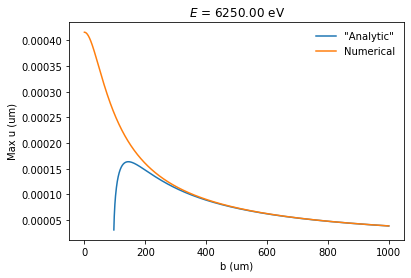

In [18]:
plt.plot(b*hbarc, max_u_analytic(E, b)*hbarc, label='"Analytic"')
plt.plot(b*hbarc, max_u_numerical(E, b)*hbarc, label='Numerical')

plt.title(fr'$E$ = {E:.2f} eV')
plt.xlabel('b (um)')
plt.ylabel('Max u (um)')
plt.legend(frameon=False)

In [19]:
max_u = max_u_numerical(E, b)

### Integrate for scattering angle

To calculate the scattering angle $\Theta$ as a function of DM energy $E$ and impact parameter $b$, we will use the following formula
$$
\begin{aligned}
    \Psi(b) &= \int_{r_\text{min}}^\infty \frac{(b/r^2) dr}{\sqrt{(1 - V(r)/E_\text{cm} - b^2/r^2)}} \\
              &= \int_0^{u_\text{max}} \frac{b du}{\sqrt{(1 - V(u)/E_\text{cm} - b^2u^2)}},
\end{aligned}
$$
where $\Psi$ is the change of angle when moving through the central force field and $E_\text{cm}$ is the total energy in the CM frame (equals to DM kinetic energy).

The scattering angle is
$$
    \Theta(b) = \pi - 2 \cdot \Psi(b).
$$
This is actually the scattering angle in the CM frame, but we assume the sphere is very heavy so it's the same as $\theta$, the scattering angle in the lab frame.

To summarize, for a fix kinetic energy (so a fix velocity), this function calculate the scattering angle $\theta(b)$ as a function of the impact parameter $b$.

In [40]:
from scipy.integrate import quad_vec

def integrand(u, E, _b):
    """
    Integrand for scattering angle calculation
    
    Parameters
    ----------
    u : float
    E : float
        CM energy in eV
    _b : float
        Impact parameter in eV^-1
        
    Returns
    -------
    float
        Max u value.
    
    """    
    sval = 1 - vtot_func(u)/E - (_b*u)**2
    if sval < 1e-10:  # cut off bad values that should be zero
        sval= np.inf

    integ = _b / np.sqrt(sval)
    return integ

Check the behavior of the integrand for a certain impact parameter (the integrand seems to hit numerical issues when approaching umax, so we manually set unreasonable numbers to zero, that's why the integrand goes to zero at max $u$).

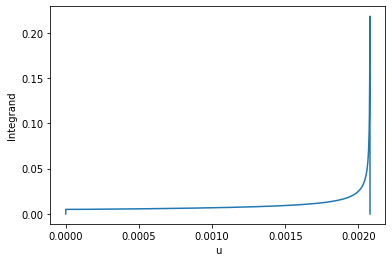

In [21]:
idx = [0]
for i in idx:
    _b = b[i]
    umax = max_u[i]
    
    ulist = np.linspace(0, umax, 2000)
    integ = np.empty_like(ulist)
    for i, u in enumerate(ulist):
        integ[i] = integrand(u, E, _b)
    plt.plot(ulist, integ)
    plt.xlabel('u')
    plt.ylabel('Integrand')

In [22]:
Psi = np.empty_like(b)
for i, _b in enumerate(b):
    umax = max_u[i]
    _b = b[i]
    Psi[i] = quad(integrand, 0, umax, args=(E, _b))[0]

In [23]:
theta = np.pi - 2 * Psi

Text(0, 0.5, '$\\theta(b)$')

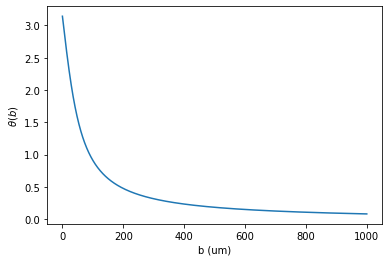

In [24]:
plt.plot(b*hbarc, theta)
plt.xlabel('b (um)')
plt.ylabel(r'$\theta(b)$')

Check the result with Dave's code

In [25]:
bvec = b
Psi_dave = np.empty_like(b)

def vtot_dave(u):
    if(u <= 0):
        return np.inf
    elif(u < 1/R):
        if(mR > 0):
            return 3*alpha/mR**3 * (mR * np.cosh(mR) - np.sinh(mR)) * np.exp(-m_phi/u) * u
        else:
            return alpha * u
    else:
        if(mR > 0):
            return 3*alpha/mR**3 * (m_phi - u*(1 + mR)/(1+1./np.tanh(mR)) * (np.sinh(m_phi/u)/np.sinh(mR)))
        else:
            return alpha/2 * (3/R - 1./(R**3 * u**2)) 
        
## integrand needed for finding the scattering angle as a function of impact parameter
def integ(u, b, E):
    sval = 1 - vtot_dave(u)/E - (b*u)**2
    #print(u,b,E,vtot(u)/E, b*u, sval)
    if(sval >= 0):
        integ = b/np.sqrt(sval)
    else:
        integ = 0
    return integ

def integ_out(u, b, E):
    if(u <= 0):
        sval = 0
    else:
        if(mR > 0):
            sval = 3*alpha/mR**3 * (mR * np.cosh(mR) - np.sinh(mR)) * np.exp(-m_phi/u) * u
        else:
            sval = alpha * u
    return b/np.sqrt(1 - sval/E - (b*u)**2)

def integ_in(u, b, E):
    if(u <= 0):
        sval = 0
    else:
        if(mR > 0):
            sval = 3*alpha/mR**3 * (m_phi - u*(1 + mR)/(1+1./np.tanh(mR)) * (np.sinh(m_phi/u)/np.sinh(mR)))
        else:
            sval = alpha/2 * (3/R - 1./(R**3 * u**2))
    return b/np.sqrt(1 - sval/E - (b*u)**2)

def minr_func(u,b,E):
        return np.abs( 1 - (b*u)**2 - vtot(u)/E)

for i, b in enumerate(bvec):
    
    min_un = minimize_scalar(minr_func, args=(b,E),bounds=(hbarc/1e3,hbarc/1e-3),method='bounded',options={'disp': 0, 'xatol': 1e-15})
    min_u = min_un.x

    ## split the integral into two pieces, to handle the diverging piece only over a small range
    ## this substantially improves the performance of quad
    int_res1 = quad(integ, min_u/1e7, min_u*0.9, args=(b,E)) #, limit=1000, full_output=1)
    int_res2 = quad(integ, min_u*0.9, min_u, args=(b,E)) #, limit=1000, full_output=1)
    int_res = int_res1[0] + int_res2[0]

    ## now try to be smarter:
    if( min_u < 1./R ):
        int_res1_check = quad(integ_out, 0, min_u, args=(b,E))
        int_res_check = int_res1_check[0]
    else:
        int_res1_check = quad(integ_out, 0, 1./R, args=(b,E))
        int_res2_check = quad(integ_in, 1./R, min_u, args=(b,E))
        int_res_check = int_res1_check[0] + int_res2_check[0]
        
    if( np.abs(int_res-int_res_check)/int_res > 1e-5 ): int_res = np.nan
    Psi_dave[i] = int_res

theta_dave = np.pi - 2 * Psi_dave

# Just to reset the "b" variable to our vector...
b = bvec

C:\Users\yuhan\AppData\Local\Temp\ipykernel_43948\895003642.py:64: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  int_res1_check = quad(integ_out, 0, min_u, args=(b,E))
C:\Users\yuhan\AppData\Local\Temp\ipykernel_43948\895003642.py:59: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  int_res2 = quad(integ, min_u*0.9, min_u, args=(b,E)) #, limit=1000, full_output=1)
C:\Users\yuhan\AppData\Local\Temp\ipykernel_43948\895003642.py:59: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  int_res2 = quad(int

Text(0, 0.5, '$\\theta(b)$')

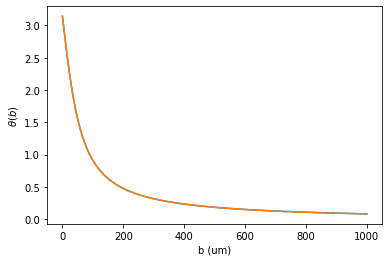

In [26]:
# Thankfully they do agree...
plt.plot(b*hbarc, theta)
plt.plot(b*hbarc, theta_dave)

plt.xlabel('b (um)')
plt.ylabel(r'$\theta(b)$')

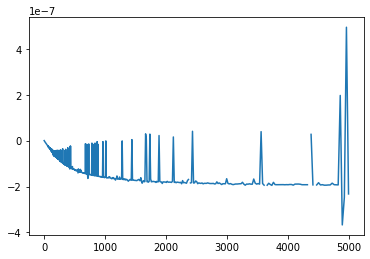

In [27]:
plt.plot(b, theta-theta_dave)

### Differential cross section

Next we want to calculate the differential cross section
$$
    \frac{d \sigma}{d \Omega} = \frac{b}{\sin{\theta}} | \frac{d b}{d \theta} |.
$$

The original impact parameters $b$ are constructued in log spacing, so we first interpolate $b$ and $\theta(b)$ into linear spacing then calculate the numerical derivative.

In [28]:
b_lin = np.linspace(start=b[0], stop=b[-1], num=b.size)
theta_lin = np.interp(b_lin, b, theta)

In [29]:
d_theta_d_b = np.gradient(theta_lin, b_lin)

Plot the numerical derivative $d \theta / d b$. It seems like there aren't funny numerical artifacts.

Text(0, 0.5, '$d \\theta / d b$')

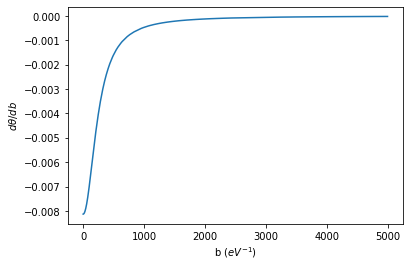

In [30]:
plt.plot(b_lin, d_theta_d_b)
plt.xlabel('b ($eV^{-1}$)')
plt.ylabel(r'$d \theta / d b$')

Plot the differential cross section $d \sigma / d \Omega$ against the scattering angle $\theta$. This is interpreted as the number of scattering between $\theta$ and $\theta + d\theta$ per unit flux. Remember that in Rutherford scattering $d \sigma / d \Omega$ falls off quicky as $\sim \frac{1}{\sin^4{(\theta / 2)}}$ so the result seems to make sense.

In [31]:
d_sigma_d_Omega = (b_lin / np.sin(theta_lin)) * np.abs(1 / d_theta_d_b)

Text(0, 0.5, '$d \\sigma / d \\Omega$')

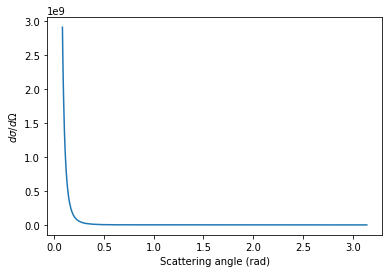

In [32]:
plt.plot(theta_lin, d_sigma_d_Omega)
plt.xlabel(r'Scattering angle (rad)')
plt.ylabel(r'$d \sigma / d \Omega$')

Now convert this to $d \sigma / d q$ where $q$ is the momentum transfer. We use the formulas
$$
    q(\theta) = 2 p \sin \frac{\theta}{2},
$$
and
$$
    \frac{d \sigma}{d q} = \frac{2 \pi q}{p^2} \frac{d \sigma}{d \Omega}.
$$
In actual analysis we want to smear this with momentum resolution of our system but let's ignore that for now.

In [33]:
q = 2 * p * np.sin(theta_lin / 2)
d_sigma_d_q = (2 * np.pi *q / (p * p)) * d_sigma_d_Omega

Plot the differential cross section as a function of momentum transfer.

Text(0, 0.5, 'Differential cross section $d \\sigma / dq$')

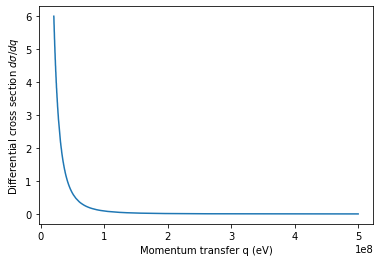

In [34]:
plt.plot(q, d_sigma_d_q)
plt.xlabel('Momentum transfer q (eV)')
plt.ylabel(r'Differential cross section $d \sigma / dq$')

### DM velocity distribution $f(v)$

The differential rate can be calculated by assuming the dark matter flux is $(\rho_{\chi} / M_\chi) \cdot v$ where $v$ is the local dark matter velocity, weighted by the DM velocity distribution:
$$
    \frac{dR}{dq} = \frac{\rho_{\chi}}{M_\chi} \int d^3 v \cdot v \cdot f(v) \frac{d \sigma}{dq}
$$

There are two choices for our purpose:

1. Asymmetric DM nugget:
https://arxiv.org/pdf/1812.07573.pdf .
See Eq. (32) and (33) of the paper. Note there is a typo in the sign of the exponential.
2. Standard halo model, which is a truncated Maxwell distribution.

We will just use the standard halo model for calculation considering a generic composite DM.

In [25]:
def f_halo(v):
    """
    DM velocity distribution in the Earth frame
    
    :param v: input velocity (array-like)
    :return: velocity distribtuion (array-like)
    """
    N0 = np.pi**1.5 * v0**3 * ( erf(vesc/v0) - 2/np.sqrt(np.pi) * (vesc/v0) * np.exp(-(vesc/v0)**2))
    
    # v < (vesc - ve)
    f1 = np.exp( - (v+ve)**2 / v0**2 ) * (np.exp(4*v*ve / v0**2) - 1)
    # (vesc - ve) < v < (vesc + ve)
    f2 = np.exp( - (v-ve)**2 / v0**2 ) - np.exp(- vesc**2 / v0**2)

    f = np.zeros_like(v)
    g1 = v < (vesc - ve)
    g2 = np.logical_and( vesc-ve < v, v < vesc + ve)
    
    f[g1] = f1[g1]
    f[g2] = f2[g2]

    return f * np.pi * v * v0**2 / (N0 * ve)

def f_halo_dan(v):
    """
    I think this is the standard halo model but need to double check.
    See Eq. (2) of https://link.aps.org/doi/10.1103/PhysRevD.42.3572
    """
    N0 = np.pi**1.5 * v0**3 * ( erf(vesc/v0) - 2/np.sqrt(np.pi) * (vesc/v0) * np.exp(-(vesc/v0)**2))
    return 4*np.pi*v**2 * np.exp(-v**2 / v0**2) / N0

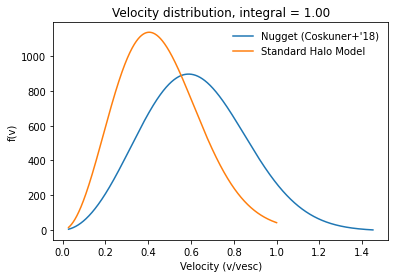

In [26]:
# Plot the DM velocity distribution
vels = np.linspace(vmin, vesc + ve, nvels)
vels_shm = np.linspace(vmin, vesc, nvels)

plt.figure()
plt.plot(vels/vesc, f_halo(vels), label='Nugget (Coskuner+\'18)')
plt.plot(vels_shm/vesc, f_halo_dan(vels_shm), label='Standard Halo Model')

plt.title(f'Velocity distribution, integral = {np.trapz(f_halo(vels), vels):.2f}')
plt.legend(frameon=False)
plt.xlabel('Velocity (v/vesc)')
plt.ylabel('f(v)')
plt.show()

## Dark matter impulse rate

Now we can calculate the differential cross ection $\frac{d \sigma}{d q}(v)$ for a given dark matter velocity. Let's organize everything in one place.

In [35]:
def b_theta(M_X, m_phi, alpha, v):
    p = M_X * v            # DM initial momentum (eV)
    E = 1./2 * M_X * v**2  # Initial kinetic energy of incoming particle
    
    # Make a list of impact parameters
    if(m_phi > 0):
        b_um = np.logspace(-3, 3, 2000)
    else:
        b_um = np.logspace(-3, 5, 2000)
    b = b_um / hbarc       # Impact factor (eV^-1)
    
    # Calculate scattering angle `theta` for each element in `b`
    max_u = max_u_numerical(E, b)
    Psi = np.empty_like(b)
    for i, _b in enumerate(b):
        umax = max_u[i]
        _b = b[i]
        Psi[i] = quad(integrand, 0, umax, args=(E, _b))[0]
    
    theta = np.pi - 2 * Psi
    
    good_pts = np.logical_not( np.logical_or(np.isnan(theta), np.isinf(theta)) )
    theta = theta[good_pts]
    b = b[good_pts]
    
    return b, theta

In [177]:
def dsig_dq(b, theta):
    
    bcidx = np.argmax(theta)
    bcrit = b[bcidx]

    ## now need the cross section above and below bcrit
    b1, t1 = b[:bcidx], theta[:bcidx]
    b2, t2 = b[bcidx:], theta[bcidx:]

    q1 = p * np.sqrt( 2*(1-np.cos(t1)) )
    q2 = p * np.sqrt( 2*(1-np.cos(t2)) )
    q = p * np.sqrt( 2*(1-np.cos(theta)) )
    
##==============================================================================
#     ## make sure we limit the second part to only the first time we fall below threshold
#     first_fall = np.argwhere(np.logical_and( q2>q_thr, np.roll(q2, -1)<q_thr))
#     if(len(first_fall > 0)):
#         gidx2 = np.logical_and(gidx2, b2<b2[first_fall[0]])
    
#     if(len(b1) > 1 ):
#         db1 = np.abs(np.gradient(b1, q1))
#     else:
#         db1 = 0
#     db2 = np.abs(np.gradient(b2, q2))
    
#     ## in order to make the divergence in dsig/dq correct at the last bin, fit the peak
#     ## to a parabola, and estimate the max deriviate in one q bin
#     bsize = q[1] - q[0]
#     if( len(b1) > 6 ):
#         nsides = 2
#         pfit = np.polyfit(b[(bcidx-nsides):(bcidx+nsides+1)], q[(bcidx-nsides):(bcidx+nsides+1)], 2 )

#         max_loc = -pfit[1] / (2*pfit[0])
#         delt_x = np.sqrt( np.abs(bsize/pfit[0]) )
#         max_deriv = delt_x / bsize

#         ## Limit the divergence to the max per bin size
#         db1[ db1 > max_deriv] = max_deriv
#         db2[ db2 > max_deriv] = max_deriv
        
#     q_lin = np.linspace(0, 2*pmax*1.1, 10000)
#     if(len(b1) > 1 ):
#         q1_idx = np.argsort(q1)
#         dsigdq1 = np.interp(q_lin, q1[q1_idx], 2 * np.pi * b1[q1_idx] * db1[q1_idx], left=0, right=0)
#     else:
#         dsigdq1 = np.zeros_like(q_lin)
#     q2_idx = np.argsort(q2)     
#     dsigdq2 = np.interp(q_lin, q2[q2_idx], 2 * np.pi * b2[q2_idx] * db2[q2_idx], left=0, right=0)
    
#     dsigdq_tot = dsigdq1 + dsigdq2
#     dsigdq_tot[q_lin < q_thr] = 0
    
#     return q_lin, dsigdq_tot
    
##=============================================================
    
#     gidx1 = q1 > q_thr
#     gidx2 = q2 > q_thr
    
#     if(len(b1) > 1 ):
#         db1 = np.abs(np.gradient(b1, q1))
#         gidx1 = np.logical_and( gidx1, np.logical_not(np.isnan(db1)) )
#         gidx1 = np.logical_and( gidx1, np.logical_not(np.isinf(db1)) )
#     else:
#         db1 = 0
#     db2 = np.abs(np.gradient(b2, q2))
#     gidx2 = np.logical_and( gidx2, np.logical_not(np.isnan(db2)) )
#     gidx2 = np.logical_and( gidx2, np.logical_not(np.isinf(db2)) )

#     qq = np.linspace(q_thr, 2*pmax*1.1, 10000)

#     if( np.sum( gidx2 ) == 0 ):
#         return qq, np.zeros_like(qq)
    
#     ## make sure we limit the second part to only the first time we fall below threshold
#     first_fall = np.argwhere(np.logical_and( q2>q_thr, np.roll(q2, -1)<q_thr))
#     if(len(first_fall > 0)):
#         gidx2 = np.logical_and(gidx2, b2<b2[first_fall[0]])
    
#     ## find the local sigma and throw out points much above it
#     bad_vec = np.ones_like( b2 )
#     for jj in range(len(b2)):
#         min_idx = np.max( (0, jj-3) )
#         max_idx = np.min( (len(b2), jj+3) )
#         cneigh = np.hstack( (q2[min_idx:jj],q2[(jj+1):max_idx]) )
#         cneigh = cneigh[np.logical_not(np.isnan(cneigh))]
#         cneigh = cneigh[np.logical_not(np.isinf(cneigh))]
#         curr_std = np.std(cneigh)
#         curr_mean = np.median(cneigh)
#         if( q2[jj]-curr_mean > 10*curr_std ):
#             bad_vec[jj] = 0
#     gidx2 = np.logical_and(gidx2, bad_vec)        

#     ## in order to make the divergence in dsig/dq correct at the last bin, fit the peak
#     ## to a parabola, and estimate the max deriviate in one q bin
#     bsize = qq[1]-qq[0]
#     if( len(b1) > 6 ):
#         nsides = 2
#         pfit = np.polyfit(b[(bcidx-nsides):(bcidx+nsides+1)], q[(bcidx-nsides):(bcidx+nsides+1)], 2 )

#         max_loc = -pfit[1]/(2*pfit[0])
#         delt_x = np.sqrt( np.abs(bsize/pfit[0]) )
#         max_deriv = delt_x/bsize
        
#         ## Limit the divergence to the max per bin size
#         db1[ db1 > max_deriv] = max_deriv
#         db2[ db2 > max_deriv] = max_deriv
    
#     ## now resample the momentum to a uniform spacing
#     if( len(b1[gidx1]) > 1):
#         dsigdq1 = np.interp(qq, q1[gidx1], 2*np.pi*b1[gidx1]*db1[gidx1], left=0, right=0)
#     else:
#         dsigdq1 = 0
#     q2, b2, db2 = q2[gidx2], b2[gidx2], db2[gidx2]
#     dsigdq2 = np.interp(qq, q2[::-1], 2*np.pi*b2[::-1]*db2[::-1], left=0, right=0)

#     dsigdq_tot = dsigdq1+dsigdq2
#     return qq, dsigdq_tot

#===============================================================
    q_lin = np.linspace(0, 2*pmax*1.1, 10000)
    if(len(b1) > 1 ):
        q1_idx = np.argsort(q1)
        b1_cubic = CubicSpline(q1[q1_idx], b1[q1_idx])(q1[q1_idx])
        db1 = np.abs(np.gradient(b1_cubic, q1[q1_idx]))
        
    q2_idx = np.argsort(q2)
    b2_cubic = CubicSpline(q2[q2_idx], b2[q2_idx])(q2[q2_idx])
    db2 = np.abs(np.gradient(b2_cubic, q2[q2_idx]))
    
    if (len(b1) > 1 ):
        dsigdq1 = np.interp(q_lin, q1[q1_idx], 2 * np.pi * b1[q1_idx] * db1, right=0)
    else:
        dsigdq1 = np.zeros_like(q_lin)
    dsigdq2 = np.interp(q_lin, q2[q2_idx], 2 * np.pi * b2[q2_idx] * db2, right=0)

    dsigdq_tot = dsigdq1 + dsigdq2
    dsigdq_tot[q_lin < q_thr] = 0  # Cut off at the momentum threshold
    
    return q_lin, dsigdq_tot

## Debugging

In [178]:
nvels = 10      # number of velocities to include in integration
vlist = np.linspace(vmin, vesc, nvels)

nb = 2000
bb, tt = np.empty(shape=(vlist.size, nb)), np.empty(shape=(vlist.size, nb))
for idx, v in enumerate(vlist):
    print(idx)
    bb[idx], tt[idx] = b_theta(M_X, m_phi, alpha, v)

0
1


C:\Users\yuhan\anaconda3\envs\microspheres\lib\site-packages\scipy\optimize\_zeros_py.py:466: RuntimeWarning: some failed to converge after 50 iterations
  warnings.warn(msg, RuntimeWarning)
C:\Users\yuhan\AppData\Local\Temp\ipykernel_27836\3798447717.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Psi[i] = quad(integrand, 0, umax, args=(E, _b))[0]
C:\Users\yuhan\AppData\Local\Temp\ipykernel_27836\3798447717.py:18: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot

2
3
4
5
6
7
8
9


In [179]:
nq = 10000
qq, ss = np.empty(shape=(vlist.size, nq)), np.empty(shape=(vlist.size, nq))
for idx, v in enumerate(vlist):
    qq[idx], ss[idx] = dsig_dq(bb[idx], tt[idx])

Plot the differential cross section for each velocity that we consider.

In [110]:
dsdqdv_dave = np.load(r'C:\Users\yuhan\work\microspheres\code\impulse\data\mphi_1e-04\dsdqdv_rate_alpha_1.00000e-08_MX_5.00000e+03.npz', allow_pickle='True')
ss_dave = dsdqdv_dave['dsigdqdv']
qq_dave = dsdqdv_dave['q']

In [193]:
dsdq_code = np.load(r'C:\Users\yuhan\work\microspheres\code\impulse\yuhan\data\mphi_1e-04\differential_rate_alpha_1.00000e-08_MX_5.00000e+03.npz', allow_pickle='True')
dsdqdv_code = np.load(r'C:\Users\yuhan\work\microspheres\code\impulse\yuhan\data\mphi_1e-04\dsdqdv_1.00000e-08_MX_5.00000e+03.npz', allow_pickle='True')

In [194]:
dsdqdv_code.files

['qq', 'dsdqdv', 'v']

(0.0, 1.0)

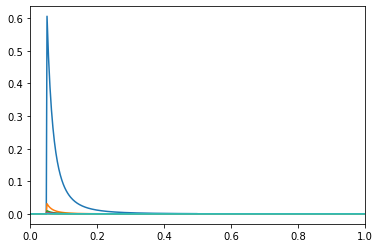

In [197]:
for i in range(10):
    plt.plot(dsdqdv_code['qq'][i], dsdqdv_code['dsdqdv'][i])
plt.xlim(0, 1)

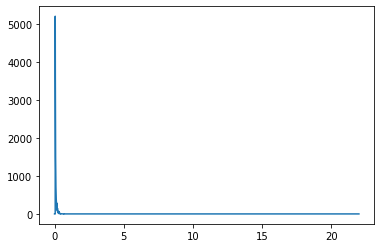

In [192]:
plt.plot(dsdq_code['q'][0], dsdq_code['dsigdq'])

In [88]:
dsdqdv_dave.files

['q', 'dsigdqdv', 'theta_b_save', 'b_um_save']

(0.0, 0.5)

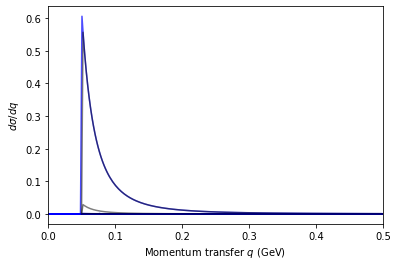

In [183]:
for i in range(10):
    plt.plot(qq[i]/1e9, ss[i], 'b', alpha=0.7)
    plt.plot(qq_dave, ss_dave[i], 'k', alpha=0.5)
plt.xlabel('Momentum transfer $q$ (GeV)')
plt.ylabel('$d \sigma / d q$')
plt.xlim(0, 0.5)

Integrate over velocities for differential rate

In [184]:
nvels = 10      # number of velocities to include in integration
vlist = np.linspace(vmin, vesc, nvels)
vlist = vlist
int_vec = rhoDM / M_X * vlist * f_halo(vlist)

tot_xsec = np.zeros(10000)
tot_xsec_dave = np.zeros(10000)
for i in range(10000):
    tot_xsec[i] = np.trapz( int_vec * ss.T[i], x=vlist )
    tot_xsec_dave[i] = np.trapz( int_vec * ss_dave.T[i], x=vlist)

(0.0, 1.0)

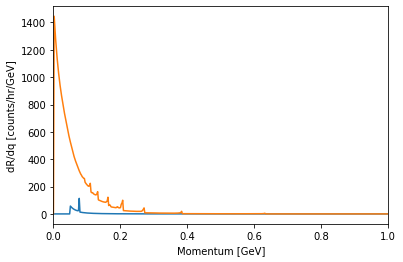

In [187]:
conv_fac = hbarc**2 * 1e9 * 3e10 * 1e-8 * 3600  # natural units -> um^2/GeV, c [cm/s], um^2/cm^2, s/hr

plt.plot( qq[0]/1e9, tot_xsec*conv_fac)
plt.plot( qq[0]/1e9, tot_xsec_dave*conv_fac)
plt.xlabel("Momentum [GeV]")
plt.ylabel("dR/dq [counts/hr/GeV]")
plt.xlim(0, 1)

In [181]:
v

0.001815

Showing result calculated by Dave's code, assuming the same 10 velocities.

(0.0, 1.0)

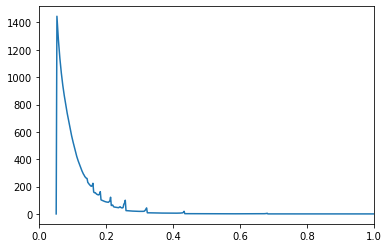

In [225]:
data = np.load(r'C:\Users\yuhan\work\microspheres\code\impulse\data\mphi_1e-04\differential_rate_alpha_1.00000e-08_MX_5.00000e+03.npz')
plt.plot(data['q'], data['dsigdq'])
plt.xlim(0, 1)

In [246]:
dsdqdv_dave = np.load(r'C:\Users\yuhan\work\microspheres\code\impulse\data\mphi_1e-04\dsdqdv_rate_alpha_1.00000e-08_MX_5.00000e+03.npz', allow_pickle='True')

In [247]:
dsdqdv_dave.files

['q', 'dsigdqdv', 'theta_b_save', 'b_um_save']

(0.0, 1.0)

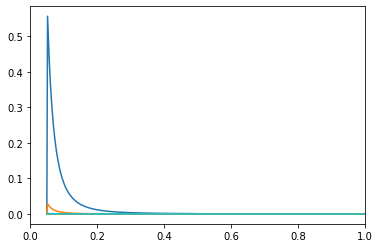

In [248]:
for i in range(10):
    plt.plot(dsdqdv_dave['q'], dsdqdv_dave['dsigdqdv'][i])
plt.xlim(0, 1)

(0.0, 1.0)

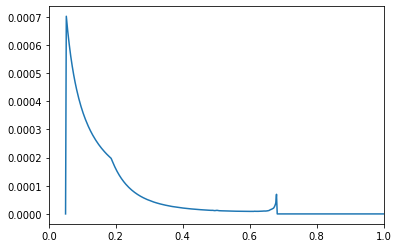

In [274]:
# plt.plot(dsdqdv_dave['q'], dsdqdv_dave['dsigdqdv'][0])
plt.plot(dsdqdv_dave['q'], dsdqdv_dave['dsigdqdv'][2])
plt.xlim(0, 1)